### Dataset info
Each chosen model went through a human assessment performed with the following methodology. Each of the assessors was given several tasks, which consisted of two parts:

1. Select one of four categories-characteristics of the provided set of tokens by answering the question ”Is it
possible to determine a common topic for the presented word set or at least for the most part of the set?”. They could answer one of the following: yes - if they agree with the statement and words have a strong connection between them, rather yes - if some words are too common or out of topic, rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, no - when words seem to be unconnected.

2. In case of answering yes or rather yes on the first part of the task, assessors were asked to mark the words that they think are out of the topic. Also, they are asked to enter the topic’s name in free form (Name the common topic with one or few words).

In [7]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import dateutil
import numpy as np
from crowdkit.aggregation import MajorityVote, Wawa, DawidSkene
import re
import matplotlib.pyplot as plt
import json

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../src'))

from data_preprocessing import TextPreprocessor

In [8]:
sns.set_style("whitegrid")

In [9]:
BASE_DIR = Path('EDA.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('data/TOLOKA_Markup')

FILE_NAME_1 = "assignments_from_pool_35355351__11-09-2022.tsv"
FILE_NAME_2 = "assignments_from_pool_35369313__12-09-2022.tsv"
FILE_NAME_3 = "assignments_from_pool_35432328__15-09-2022.tsv"
FILE_NAME_4 = "assignments_from_pool_35480971__19-09-2022.tsv"

FILE_1 = DATA_DIR.joinpath(FILE_NAME_1)
FILE_2 = DATA_DIR.joinpath(FILE_NAME_2)
FILE_3 = DATA_DIR.joinpath(FILE_NAME_3)
FILE_4 = DATA_DIR.joinpath(FILE_NAME_4)

In [10]:
df1 = pd.read_csv(FILE_1, sep="\t")
df2 = pd.read_csv(FILE_2, sep="\t")
df3 = pd.read_csv(FILE_3, sep="\t")
df4 = pd.read_csv(FILE_4, sep="\t")

data = pd.concat([df1, df2, df3, df4])

data.head(10)

,INPUT:exp_id,INPUT:wordset,INPUT:model_id,INPUT:topic_id,INPUT:dataset_name,INPUT:correct_bad_words,OUTPUT:quality,OUTPUT:bad_words,OUTPUT:topic_name,OUTPUT:golden_bad_words,...,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:submitted,ASSIGNMENT:accepted,ASSIGNMENT:rejected,ASSIGNMENT:skipped,ASSIGNMENT:expired,ASSIGNMENT:reward
0,28.0,driver sound running anybody memory wonder err...,631ba815291a690c5875365a,main24,20newsgroups,NaN,rather_bad,"{""driver"":false,""sound"":false,""running"":false,...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
1,28.0,argument colorado conclusion music letter fall...,631bb8282d85fb2da960a6a5,main72,20newsgroups,NaN,bad,"{""argument"":false,""colorado"":false,""conclusion...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
2,28.0,love uiuc cwru thought guess wrong sorry frank...,631b95224ac2fcd506e4781a,main4,20newsgroups,NaN,rather_bad,"{""love"":false,""uiuc"":false,""cwru"":false,""thoug...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
3,28.0,engine modem rocket phone model yeast level fr...,631ba1dba6fa8975eb579abd,main13,20newsgroups,NaN,rather_bad,"{""engine"":false,""modem"":false,""rocket"":false,""...",NaN,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
4,28.0,turkish turkey turk armenia greek nazi azeri s...,631b96bea5a57837b841b5d1,main28,20newsgroups,NaN,rather_good,"{""turkish"":false,""turkey"":false,""turk"":false,""...",Race,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
5,28.0,country nazi germany german land europe money ...,631bb6faa5a57837b841d979,main3,20newsgroups,NaN,rather_good,"{""country"":false,""nazi"":false,""germany"":true,""...",Germany,True,...,00021b7ad7--631df4b9a3d75c31d7b50ce1,35c9dec005edb17d8cc11946f9bc4b0f,APPROVED,2022-09-11T14:46:17.435,2022-09-11T14:48:35.368,2022-09-11T14:48:35.368,NaN,NaN,NaN,0.05
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,28.0,attack lebanese muslim hernlem israeli left tr...,631b96bea5a57837b841b5d1,main1,20newsgroups,NaN,good,"{""attack"":false,""lebanese"":false,""muslim"":fals...",War,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05
8,28.0,curve drug create libertarian email hold graph...,631bb32427e1a64b30543798,main44,20newsgroups,NaN,bad,"{""curve"":false,""drug"":false,""create"":false,""li...",NaN,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05
9,28.0,nasa earth orbit mission launch satellite moon...,631b9549939bfaaca5600f20,main8,20newsgroups,NaN,good,"{""nasa"":false,""earth"":false,""orbit"":false,""mis...",Space exploration,True,...,00021b7ad7--631df4c241d72e6d49540210,9c19d68db298943ca43bb07b3d320ac7,APPROVED,2022-09-11T14:46:26.065,2022-09-11T14:48:16.890,2022-09-11T14:48:16.890,NaN,NaN,NaN,0.05


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25922 entries, 0 to 9906
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   INPUT:correct_bad_words       0 non-null      float64
 6   OUTPUT:quality                20854 non-null  object 
 7   OUTPUT:bad_words              20854 non-null  object 
 8   OUTPUT:topic_name             9015 non-null   object 
 9   OUTPUT:golden_bad_words       20854 non-null  object 
 10  OUTPUT:golden_binary_quality  20854 non-null  object 
 11  GOLDEN:quality                0 non-null      float64
 12  GOLDEN:bad_words              0 non-null      float64
 13  GO

In [12]:
print(data.columns)

Index(['INPUT:exp_id', 'INPUT:wordset', 'INPUT:model_id', 'INPUT:topic_id',
       'INPUT:dataset_name', 'INPUT:correct_bad_words', 'OUTPUT:quality',
       'OUTPUT:bad_words', 'OUTPUT:topic_name', 'OUTPUT:golden_bad_words',
       'OUTPUT:golden_binary_quality', 'GOLDEN:quality', 'GOLDEN:bad_words',
       'GOLDEN:topic_name', 'GOLDEN:golden_bad_words',
       'GOLDEN:golden_binary_quality', 'HINT:text', 'HINT:default_language',
       'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id',
       'ASSIGNMENT:task_suite_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status',
       'ASSIGNMENT:started', 'ASSIGNMENT:submitted', 'ASSIGNMENT:accepted',
       'ASSIGNMENT:rejected', 'ASSIGNMENT:skipped', 'ASSIGNMENT:expired',
       'ASSIGNMENT:reward'],
      dtype='object')


There are columns and rows with all NaNs

In [13]:
# Remove rows with NaNs
data.dropna(axis=0, how='all', inplace=True)
# Remove columns with NaNs
data.dropna(axis=1, how='all', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22216 entries, 0 to 9905
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3706 non-null   object 
 11  ASSIGNMENT:link               22216 non-null  object 
 12  ASSIGNMENT:task_id            22216 non-null  object 
 13  AS

In [14]:
# Remove duplicates
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22216 entries, 0 to 9905
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22216 non-null  float64
 1   INPUT:wordset                 22216 non-null  object 
 2   INPUT:model_id                22216 non-null  object 
 3   INPUT:topic_id                22216 non-null  object 
 4   INPUT:dataset_name            22216 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3706 non-null   object 
 11  ASSIGNMENT:link               22216 non-null  object 
 12  ASSIGNMENT:task_id            22216 non-null  object 
 13  AS

As we can see from the information there are no duplicates 

In [15]:
# Analyze the INPUT data
data.iloc[0]["INPUT:wordset"]

'driver sound running anybody memory wonder error fine works appreciate check tape machine sorry utexas'

### Check skipped responses

In [16]:
print(f'The number of skipped responses: {len(data[data["ASSIGNMENT:skipped"].notnull()])}')
# Remove all skipped responses
data = data[data["ASSIGNMENT:skipped"].isna()]
# Remove skipped column
data.drop(labels=["ASSIGNMENT:skipped"], axis=1, inplace=True)
print(data.info())

The number of skipped responses: 36
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22180 entries, 0 to 9877
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  22180 non-null  float64
 1   INPUT:wordset                 22180 non-null  object 
 2   INPUT:model_id                22180 non-null  object 
 3   INPUT:topic_id                22180 non-null  object 
 4   INPUT:dataset_name            22180 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3700 non-null   object 
 11  ASSIGNMENT:link               22180 non-null  object 
 12  ASSIGNMENT:task_id       

### Check expared responses

In [17]:
print(f'The number of expared responses: {len(data[data["ASSIGNMENT:expired"].notnull()])}')
# Remove all expired responses
data = data[data["ASSIGNMENT:expired"].isna()]
# Remove expired column
data.drop(labels=["ASSIGNMENT:expired"], axis=1, inplace=True)
print(data.info())

The number of expared responses: 1326
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20854 entries, 0 to 9240
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   INPUT:exp_id                  20854 non-null  float64
 1   INPUT:wordset                 20854 non-null  object 
 2   INPUT:model_id                20854 non-null  object 
 3   INPUT:topic_id                20854 non-null  object 
 4   INPUT:dataset_name            20854 non-null  object 
 5   OUTPUT:quality                20854 non-null  object 
 6   OUTPUT:bad_words              20854 non-null  object 
 7   OUTPUT:topic_name             9015 non-null   object 
 8   OUTPUT:golden_bad_words       20854 non-null  object 
 9   OUTPUT:golden_binary_quality  20854 non-null  object 
 10  GOLDEN:golden_binary_quality  3479 non-null   object 
 11  ASSIGNMENT:link               20854 non-null  object 
 12  ASSIGNMENT:task_id     

### Calculate the duration of the response

In [18]:
# Convert from str to datetime
to_datetime = lambda x: dateutil.parser.parse(x)

data["ASSIGNMENT:submitted"] = [to_datetime(date) for date in data["ASSIGNMENT:submitted"].values]
data["ASSIGNMENT:started"] = [to_datetime(date) for date in data["ASSIGNMENT:started"].values]

data["ASSIGMNENT:time"] = data["ASSIGNMENT:submitted"] - data["ASSIGNMENT:started"]

to_seconds = lambda x: x.seconds 

data["ASSIGMNENT:time"] = [to_seconds(date) for date in data["ASSIGMNENT:time"]]
time_diff = data["ASSIGMNENT:time"].value_counts(ascending=True)

print(f"Minimum response time: {min(time_diff)} sec")
print(f"Maximum response time: {max(time_diff)} sec")

Minimum response time: 5 sec
Maximum response time: 168 sec


### Check experts

In [19]:
print(f'Experts: {len(set(data["ASSIGNMENT:worker_id"]))}')

Experts: 912


In [20]:
# Extract the distribution of responses
exp_ans_distrib = pd.DataFrame(data.groupby(["ASSIGNMENT:worker_id", "OUTPUT:quality"])["INPUT:topic_id"].count())
print(exp_ans_distrib)

                                                 INPUT:topic_id
ASSIGNMENT:worker_id             OUTPUT:quality                
00050088af76d06a6247012e98a87023 bad                          2
                                 good                         3
                                 rather_good                  1
008376462dbb509cc4a6c6a8155d29b5 good                         5
                                 rather_bad                   4
...                                                         ...
ffae26b6389ae0b44c2ed2e536a5f996 rather_good                  1
ffc5d2a1ec57e1fdabf2151abf1ca025 bad                          2
                                 good                         1
                                 rather_bad                   1
                                 rather_good                  2

[2606 rows x 1 columns]


In [21]:
print(f"The number of unique input texts: {len(set(data['INPUT:wordset']))}")

The number of unique input texts: 3861


### Data preproccessing for topic_name

1) Lowercase

2) Remove punctuation 

3) Remove extra spaces

4) Tokenization 

5) Remove stop-words

6) Lemmatization (?)

In [22]:
data_preprocessor = TextPreprocessor(lang='eng')

In [23]:
example = 'Womans Thrashed in   a hotel room   !'
print(example)
example = data_preprocessor.lower_topic(example)
print(example)
example = data_preprocessor.remove_ext_spaces(example)
print(example)
example = data_preprocessor.remove_punct(example)
print(example)
example = data_preprocessor.tokenize(example)
print(example)
example = data_preprocessor.remove_stop_words(example)
print(example)
example = data_preprocessor.lemmatize(example)
print(example)

Womans Thrashed in   a hotel room   !
womans thrashed in   a hotel room   !
womans thrashed in a hotel room !
womans thrashed in a hotel room 
['womans', 'thrashed', 'in', 'a', 'hotel', 'room']
['womans', 'thrashed', 'hotel', 'room']
woman thrashed hotel room


In [24]:
data_preprocessor = TextPreprocessor(lang='eng')

data["OUTPUT:topic_name"] = [data_preprocessor.lower_topic(topic) for topic in data["OUTPUT:topic_name"]]
# data["OUTPUT:topic_name"] = [data_preprocessor.remove_ext_spaces(topic) for topic in data["OUTPUT:topic_name"]]
# data["OUTPUT:topic_name"] = [data_preprocessor.remove_punct(topic) for topic in data["OUTPUT:topic_name"]]
# data["OUTPUT:topic_name"] = [data_preprocessor.tokenize(topic) for topic in data["OUTPUT:topic_name"]]
# data["OUTPUT:topic_name"] = [data_preprocessor.remove_stop_words(topic) for topic in data["OUTPUT:topic_name"]]
# data["OUTPUT:topic_name"] = [data_preprocessor.lemmatize(topic) for topic in data["OUTPUT:topic_name"]]

### Extract main inforamation

In [25]:
print("OUTPUT:golden_bad_words", set(data["OUTPUT:golden_bad_words"]))
print("OUTPUT:golden_binary_quality", set(data["OUTPUT:golden_binary_quality"]))
print("GOLDEN:golden_binary_quality", set(data["GOLDEN:golden_binary_quality"]))

OUTPUT:golden_bad_words {True}
OUTPUT:golden_binary_quality {False, True}
GOLDEN:golden_binary_quality {nan, True, False}


In [26]:
data = data[["ASSIGNMENT:worker_id", "INPUT:wordset", "OUTPUT:quality", "OUTPUT:bad_words", "OUTPUT:topic_name", "INPUT:dataset_name"]]
data

,ASSIGNMENT:worker_id,INPUT:wordset,OUTPUT:quality,OUTPUT:bad_words,OUTPUT:topic_name,INPUT:dataset_name
0,35c9dec005edb17d8cc11946f9bc4b0f,driver sound running anybody memory wonder err...,rather_bad,"{""driver"":false,""sound"":false,""running"":false,...",NaN,20newsgroups
1,35c9dec005edb17d8cc11946f9bc4b0f,argument colorado conclusion music letter fall...,bad,"{""argument"":false,""colorado"":false,""conclusion...",NaN,20newsgroups
2,35c9dec005edb17d8cc11946f9bc4b0f,love uiuc cwru thought guess wrong sorry frank...,rather_bad,"{""love"":false,""uiuc"":false,""cwru"":false,""thoug...",NaN,20newsgroups
3,35c9dec005edb17d8cc11946f9bc4b0f,engine modem rocket phone model yeast level fr...,rather_bad,"{""engine"":false,""modem"":false,""rocket"":false,""...",NaN,20newsgroups
4,35c9dec005edb17d8cc11946f9bc4b0f,turkish turkey turk armenia greek nazi azeri s...,rather_good,"{""turkish"":false,""turkey"":false,""turk"":false,""...",race,20newsgroups
...,...,...,...,...,...,...
9236,e50fd70d232733661aef53b7e31c083b,favorite enough blend black fuel fruity jet ro...,rather_bad,"{""favorite"":false,""enough"":false,""blend"":false...",NaN,amazon_food
9237,e50fd70d232733661aef53b7e31c083b,israel pres israeli encryption security arab c...,bad,"{""israel"":false,""pres"":false,""israeli"":false,""...",NaN,20newsgroups
9238,e50fd70d232733661aef53b7e31c083b,ingredient natural corn free gluten chicken sy...,good,"{""ingredient"":false,""natural"":false,""corn"":fal...",pet diet,amazon_food
9239,e50fd70d232733661aef53b7e31c083b,anything juice wrong guess throw immediately t...,bad,"{""anything"":false,""juice"":false,""wrong"":false,...",NaN,amazon_food


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20854 entries, 0 to 9240
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ASSIGNMENT:worker_id  20854 non-null  object
 1   INPUT:wordset         20854 non-null  object
 2   OUTPUT:quality        20854 non-null  object
 3   OUTPUT:bad_words      20854 non-null  object
 4   OUTPUT:topic_name     9015 non-null   object
 5   INPUT:dataset_name    20854 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


In [23]:
data.loc[9240]["OUTPUT:bad_words"]

'{"espresso":false,"cappuccino":false,"illy":true,"drink":false,"mate":false,"capsule":false,"http":true,"href":true,"com":true,"www":true,"issimo":true,"caffe":false,"roast":false,"dark":false,"cold":false}'

### Aggregations


In [35]:
# Extract unique wordsets with dataset_name
datasets_name = pd.DataFrame(data.groupby(["INPUT:wordset", "INPUT:dataset_name"])["ASSIGNMENT:worker_id"].count())
datasets_name

,,ASSIGNMENT:worker_id
INPUT:wordset,INPUT:dataset_name,
able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter,amazon_food,3
able amaze fill stop glad daily fantastic move plenty prime empty job subtle strongly litter,amazon_food,12
able amaze fill stop glad daily fantastic move plenty prime empty subtle job strongly litter,amazon_food,3
able amaze glad fill stop fantastic daily move prime empty plenty subtle job strongly litter,amazon_food,3
absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application,20newsgroups,5
...,...,...
year two size old every last month start since week several baby long three ago,amazon_food,3
year two size old every last month start week since several baby long ago three,amazon_food,6
year two size old last month every start week since baby several long ago three,amazon_food,3


In [36]:
DATA_DIR = BASE_DIR.joinpath('data/datasets')

FILE_NAME = "datasets_name.csv"

FILE = DATA_DIR.joinpath(FILE_NAME)

datasets_name.to_csv(FILE)

                                                                   ASSIGNMENT:worker_id
INPUT:wordset                                      OUTPUT:quality                      
able amaze fill glad stop daily fantastic move ... bad                                1
                                                   rather_bad                         2
able amaze fill stop glad daily fantastic move ... bad                                4
                                                   good                               1
                                                   rather_bad                         6
...                                                                                 ...
year two size old last month every start week s... good                               1
                                                   rather_bad                         1
year work two every size old last month start l... bad                                2
                                

<Axes: xlabel='OUTPUT:quality', ylabel='count'>

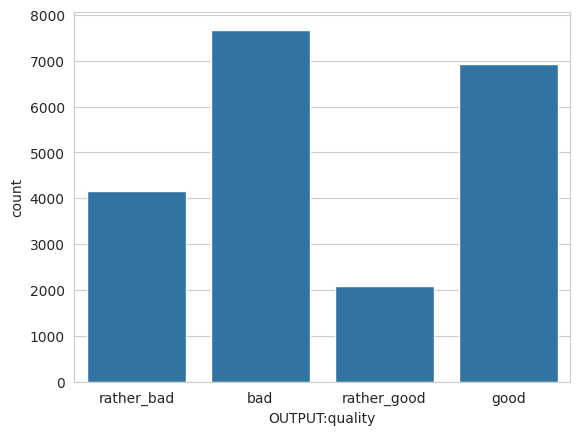

In [24]:
# Extract the distribution of responses (in entire dataset)
quality_distrib = pd.DataFrame(data.groupby(["INPUT:wordset", "OUTPUT:quality"])["ASSIGNMENT:worker_id"].count())
print(quality_distrib)
sns.countplot(data=data, x="OUTPUT:quality")

As we can see the data is poorly balanced. Let's combine good/rather_good and bad/raher_bad

                INPUT:wordset
OUTPUT:quality               
bad                     11839
good                     9015


<Axes: xlabel='OUTPUT:quality', ylabel='count'>

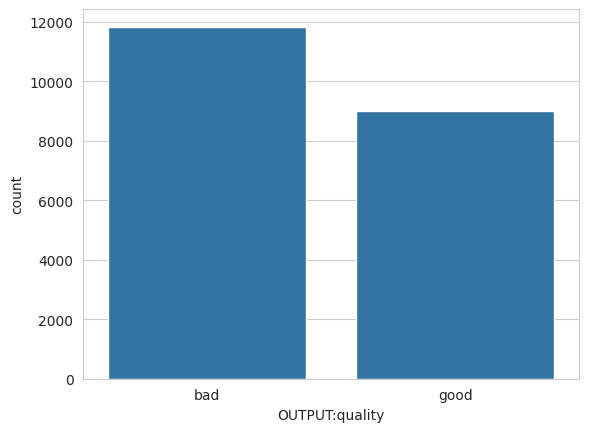

In [25]:
data_tmp = data.copy()
data_tmp["OUTPUT:quality"] = ["good" if answ in ["good", "rather_good"] else "bad" for answ in data["OUTPUT:quality"]]
# Extract the distribution of responses (in entire dataset)
quality_distrib_2 = pd.DataFrame(data_tmp.groupby(["OUTPUT:quality"])["INPUT:wordset"].count())
print(quality_distrib_2)
sns.countplot(data=data_tmp, x="OUTPUT:quality")

In this case we obtain more balanced classes.

**Task:** binary classification (traditional approaches->Catboost, LLM)

Let's check how quality is distributed within one wordset

In [26]:
wordset_quality_distrib = pd.DataFrame(data.groupby(["INPUT:wordset","OUTPUT:quality"])["OUTPUT:bad_words"].count())
wordset_quality_distrib

OUTPUT:bad_words
INPUT:wordset                                      OUTPUT:quality                  
able amaze fill glad stop daily fantastic move ... bad                            1
                                                   rather_bad                     2
able amaze fill stop glad daily fantastic move ... bad                            4
                                                   good                           1
                                                   rather_bad                     6
...                                                                             ...
year two size old last month every start week s... good                           1
                                                   rather_bad                     1
year work two every size old last month start l... bad                            2
                                                   rather_bad                     1
year work two size old last month start long we... bad                            3

[8786 rows x 1 columns]

The number of unique wordest: 8786

### Crowd-Kit aggregations

Read the annotations into Pandas Data Frame with columns task, worker, label.

Wawa: It calculates the majority opinion, and then re-weighs the performers' votes using the proportion of responses that coincided with the majority opinion.

In [27]:
def crowd_kit_agg(df):
    tmp_df = df.copy()
    tmp_df = tmp_df.rename(columns={"ASSIGNMENT:worker_id": "worker", "INPUT:wordset": "task", "OUTPUT:quality": "label"})

    # Majority Vote Aggregation
    agg_mv = MajorityVote().fit_predict(tmp_df)
    # Wawa 
    agg_wawa = Wawa().fit_predict(tmp_df)
    # Dawid Skene
    agg_ds = DawidSkene(n_iter=10).fit_predict(tmp_df)

    # Let's compare the results
    ids = agg_mv.index

    agg_wawa = agg_wawa[ids]
    agg_ds = agg_ds[ids]

    mv_wawa = agg_mv == agg_wawa
    mv_ds = agg_mv == agg_ds
    wawa_ds = agg_wawa == agg_ds

    print(f"Majority Vote vs Wawa: True - {sum(mv_wawa)} False - {len(mv_wawa)-sum(mv_wawa)}")
    print(f"Majority Vote vs Dawid Skene: True - {sum(mv_ds)} False - {len(mv_ds)-sum(mv_ds)}")
    print(f"Wawa vs Dawid Skene: True - {sum(wawa_ds)} False - {len(wawa_ds)-sum(wawa_ds)}")

    agg_mv2 = pd.DataFrame(agg_mv)
    agg_wawa2 = pd.DataFrame(agg_wawa)
    agg_ds2 = pd.DataFrame(agg_ds)
    
    # Determine number of classes
    classes_num = len(set(tmp_df["label"]))
    
    fig = plt.figure(figsize=(15,10))
    plt.suptitle(f"The number of classes: {classes_num}", fontsize = 18)

    plt.subplot(131)
    plt.title('Majority Vote')
    sns.countplot(data=agg_mv2, x='agg_label')

    plt.subplot(132)
    plt.title('Wawa')
    sns.countplot(data=agg_wawa2, x='agg_label')

    plt.subplot(133)
    plt.title('Dawid Skene')
    sns.countplot(data=agg_ds2, x='agg_label')

    plt.tight_layout()
    plt.show()

    return agg_mv2, agg_wawa2, agg_ds2

/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/alexandra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Majority Vote vs Wawa: True - 3682 False - 179
Majority Vote vs Dawid Skene: True - 2707 False - 1154
Wawa vs Dawid Skene: True - 2728 False - 1133


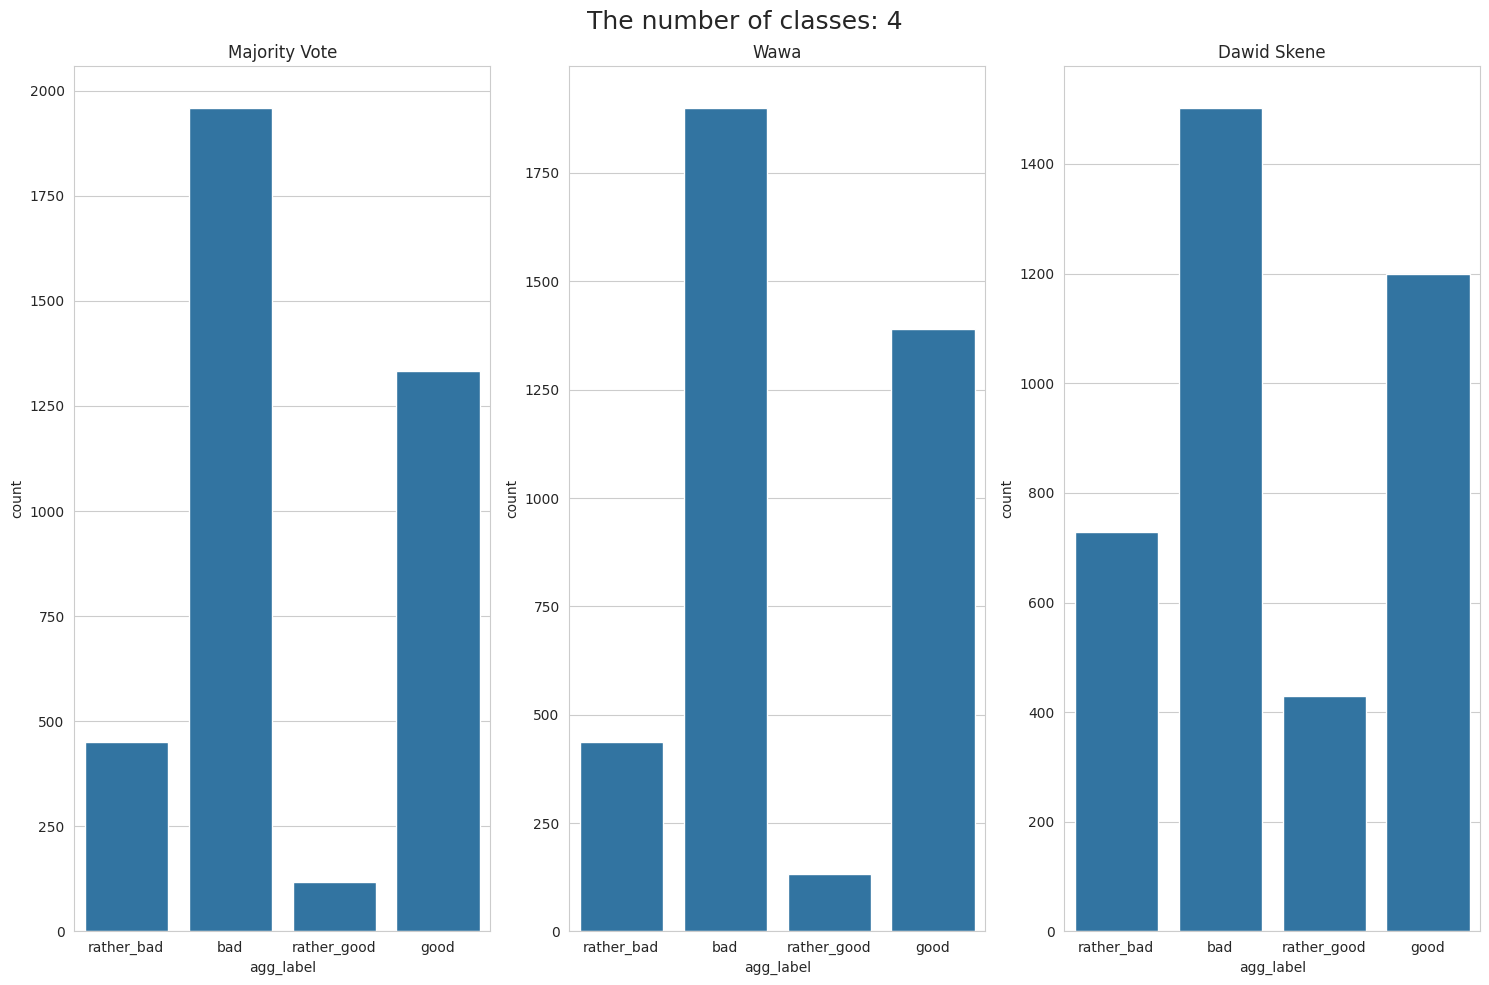

In [28]:
# For 4 classes
agg_mv, agg_wawa, agg_ds = crowd_kit_agg(data)

Majority Vote vs Wawa: True - 3856 False - 5
Majority Vote vs Dawid Skene: True - 3599 False - 262
Wawa vs Dawid Skene: True - 3604 False - 257


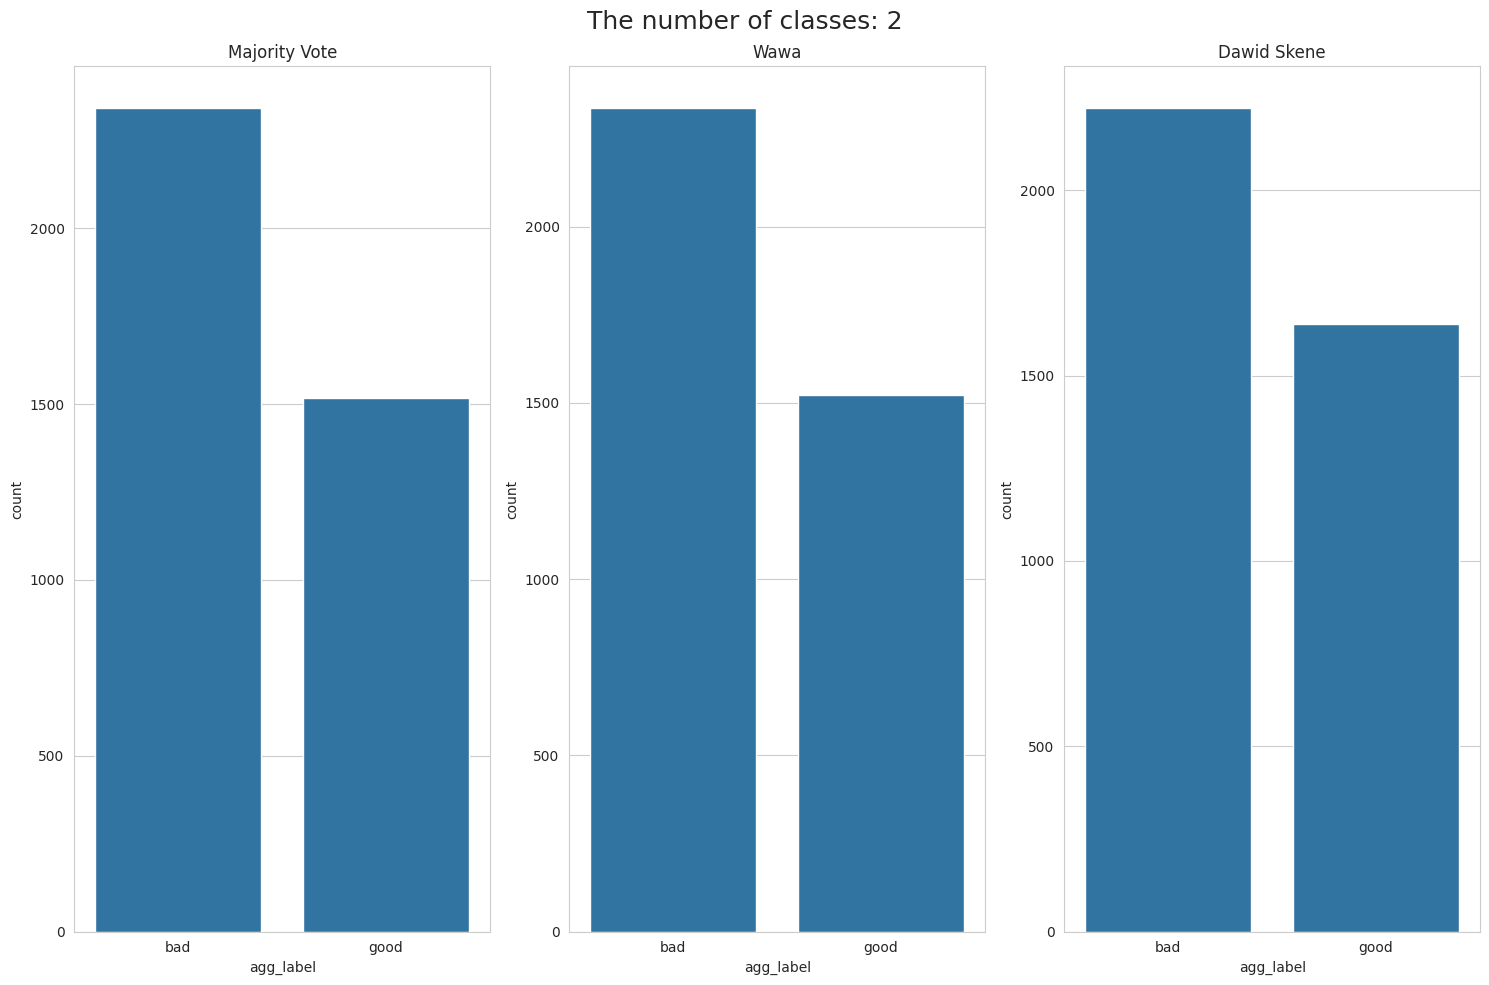

In [29]:
# For 2 classes
agg_mv, agg_wawa, agg_ds = crowd_kit_agg(data_tmp)

In [30]:
agg_mv

,agg_label
task,
able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter,bad
able amaze fill stop glad daily fantastic move plenty prime empty job subtle strongly litter,bad
able amaze fill stop glad daily fantastic move plenty prime empty subtle job strongly litter,bad
able amaze glad fill stop fantastic daily move prime empty plenty subtle job strongly litter,bad
absolute church truth doug scripture symbol libxmu font bible free undefined type motif error application,good
...,...
year two size old every last month start since week several baby long three ago,bad
year two size old every last month start week since several baby long ago three,good
year two size old last month every start week since baby several long ago three,bad


In [31]:
DATA_DIR = BASE_DIR.joinpath('data/datasets')

FILE_NAME = "data_quality_estim.csv"

FILE = DATA_DIR.joinpath(FILE_NAME)

agg_mv.to_csv(FILE)

### topic_name analysis

In [32]:
# Get only good quality samples 
data_good = data[data["OUTPUT:quality"] == "good"]

topic_name_distrib = pd.DataFrame(data_good.groupby(["INPUT:wordset","OUTPUT:quality", "OUTPUT:topic_name"])["OUTPUT:bad_words"].count())
topic_name_distrib = topic_name_distrib.rename(columns={"OUTPUT:bad_words": "topic_name_num"})
topic_name_distrib

topic_name_num
INPUT:wordset                                      OUTPUT:quality OUTPUT:topic_name                
able amaze fill stop glad daily fantastic move ... good           feelings                        1
absolute mission church nasa mars earth truth l... good           astrology                       1
                                                                  nasa                            1
                                                                  space                           1
                                                                  space mission                   1
...                                                                                             ...
year two size old every last month start since ... good           year                            1
year two size old every last month start week s... good           baby                            1
                                                                  child                           1
                                                                  time                            1
year two size old last month every start week s... good           time                            1

[5766 rows x 1 columns]

In [33]:
topic_name_distrib.value_counts()

topic_name_num
1                 5143
2                  444
3                   94
4                   34
5                   14
6                    9
8                    5
10                   5
7                    4
14                   3
15                   2
23                   2
19                   2
9                    2
13                   1
11                   1
32                   1
dtype: int64

In [34]:
topic_name_distrib[topic_name_distrib["topic_name_num"]==32]

,,,topic_name_num
INPUT:wordset,OUTPUT:quality,OUTPUT:topic_name,
kill child weapon crime fire firearm woman drug death carry police criminal city court bill,good,crime,32


In [35]:
topic_name_distrib[topic_name_distrib["topic_name_num"]==10]

,,,topic_name_num
INPUT:wordset,OUTPUT:quality,OUTPUT:topic_name,
appreciate email anybody advance experience info thank wonder suggestion send hello greatly response recently advice,good,email,10
bible religion turkish church belief truth argument faith christ atheist muslim greek ence human word,good,religion,10
bible religion turkish church belief truth argument faith christ atheist muslim greek human ence word,good,religion,10
doctor disease patient treatment cand treat cause test medicine yeast blood symptom medical ence body,good,medical,10
health cancer medical national increase research center fnal higgins newsletter word volume page among report,good,health,10


In [36]:
DATA_DIR = BASE_DIR.joinpath('data/datasets')

FILE_NAME = "data_topic_name_distrib.csv"

FILE = DATA_DIR.joinpath(FILE_NAME)

topic_name_distrib.to_csv(FILE)

### Bad words analysis

In [55]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [37]:
data_good

,ASSIGNMENT:worker_id,INPUT:wordset,OUTPUT:quality,OUTPUT:bad_words,OUTPUT:topic_name
7,9c19d68db298943ca43bb07b3d320ac7,attack lebanese muslim hernlem israeli left tr...,good,"{""attack"":false,""lebanese"":false,""muslim"":fals...",war
9,9c19d68db298943ca43bb07b3d320ac7,nasa earth orbit mission launch satellite moon...,good,"{""nasa"":false,""earth"":false,""orbit"":false,""mis...",space exploration
10,9c19d68db298943ca43bb07b3d320ac7,monitor price board apple port simms sell slot...,good,"{""monitor"":false,""price"":false,""board"":false,""...",computers
15,2dd259f0651eb9f893d4581088e432e2,nasa earth orbit mission launch satellite moon...,good,"{""nasa"":true,""earth"":true,""orbit"":true,""missio...",space
18,2dd259f0651eb9f893d4581088e432e2,image graphics format user package unix code m...,good,"{""image"":true,""graphics"":true,""format"":true,""u...",computer
...,...,...,...,...,...
9226,c0b27612745c036069689c4124bf3665,salt bean dish cooking sea kitchen gourmet tab...,good,"{""salt"":false,""bean"":false,""dish"":false,""cooki...",food
9228,6b27f1d44e869a8c64e1c68a5ecfd854,salt bean dish cooking sea kitchen gourmet tab...,good,"{""salt"":false,""bean"":false,""dish"":false,""cooki...",dish
9231,6b27f1d44e869a8c64e1c68a5ecfd854,disk scsi speed controller fast port card mode...,good,"{""disk"":false,""scsi"":false,""speed"":false,""cont...",controller
9232,6b27f1d44e869a8c64e1c68a5ecfd854,stuff coconut case health tell difference plea...,good,"{""stuff"":false,""coconut"":false,""case"":false,""h...",coconut


In [38]:
# Aggregate by text and bad_words
bad_words_distrib = pd.DataFrame(data_good.groupby(["INPUT:wordset","OUTPUT:bad_words"])["OUTPUT:topic_name"].count())
bad_words_distrib

OUTPUT:topic_name
INPUT:wordset                                      OUTPUT:bad_words                                                     
able amaze fill stop glad daily fantastic move ... {"able":false,"amaze":false,"fill":true,"stop":...                  1
absolute mission church nasa mars earth truth l... {"absolute":false,"mission":false,"church":fals...                  1
                                                   {"absolute":false,"mission":true,"church":false...                  1
                                                   {"absolute":true,"mission":false,"church":true,...                  1
                                                   {"church":false,"symbol":false,"earth":false,"m...                  1
...                                                                                                                  ...
year two size old every last month start since ... {"year":false,"two":false,"size":false,"old":fa...                  1
year two size old every last month start week s... {"year":false,"two":false,"size":false,"old":fa...                  1
                                                   {"year":false,"two":false,"size":false,"old":fa...                  1
                                                   {"year":false,"two":false,"size":false,"old":fa...                  1
year two size old last month every start week s... {"year":false,"two":false,"size":true,"old":fal...                  1

[5530 rows x 1 columns]

In [39]:
bad_words_distrib.value_counts()

OUTPUT:topic_name
1                    4853
2                     431
3                     136
4                      44
5                      20
6                      12
9                       6
7                       5
8                       4
11                      3
13                      2
24                      2
12                      2
10                      2
14                      1
15                      1
16                      1
20                      1
25                      1
26                      1
29                      1
33                      1
dtype: int64

In [40]:
bad_words_distrib[bad_words_distrib["OUTPUT:topic_name"]==33]

,,OUTPUT:topic_name
INPUT:wordset,OUTPUT:bad_words,
price sell shipping cheap purchase dealer selling deal sale phone plus sales package company cost,"{""price"":false,""sell"":false,""shipping"":false,""cheap"":false,""purchase"":false,""dealer"":false,""selling"":false,""deal"":false,""sale"":false,""phone"":false,""plus"":false,""sales"":false,""package"":false,""company"":false,""cost"":false}",33


In [41]:
bad_words_distrib.iloc[3]

OUTPUT:topic_name    1
Name: (absolute mission church nasa mars earth truth lunar shuttle doug telescope symbol planetary libxmu launch, {"absolute":true,"mission":false,"church":true,"nasa":false,"mars":false,"earth":false,"truth":true,"lunar":false,"shuttle":false,"doug":true,"telescope":false,"symbol":true,"planetary":false,"libxmu":true,"launch":false}), dtype: int64

In [47]:
bad_lst = data_good["OUTPUT:bad_words"]
bad_lst.iloc[0]

'{"attack":false,"lebanese":false,"muslim":false,"hernlem":true,"israeli":false,"left":true,"troops":false,"peace":false,"fire":false,"away":true,"quite":true,"stop":false,"religion":false,"israel":false,"especially":true}'

In [52]:
json.loads(bad_lst.iloc[0])

{'attack': False,
 'lebanese': False,
 'muslim': False,
 'hernlem': True,
 'israeli': False,
 'left': True,
 'troops': False,
 'peace': False,
 'fire': False,
 'away': True,
 'quite': True,
 'stop': False,
 'religion': False,
 'israel': False,
 'especially': True}

In [70]:
wordsets_lst = []
unsuitable_topics = []
suitable_topics = []
all_topics = []

# Извлечь одинаковые наборы текстов
# Извлечь все топики
# Извлечь топики со значение True, взять union
# Извлечь топики со значением False, взять пересечение
all_wordsets = list(set(data_good["INPUT:wordset"]))

for wordset in all_wordsets:
    wordsets_lst.append(wordset)
    bedwords_df = data_good[data_good["INPUT:wordset"]==wordset]
    bedwords_true = []
    topics = list(json.loads(bedwords_df["OUTPUT:bad_words"].iloc[0]).keys())
    all_topics.append(topics)
    bedwords_false = topics.copy()
    for bedwords_lst in bedwords_df["OUTPUT:bad_words"]:
        bedwords_dict = json.loads(bedwords_lst)
        bedwords_true.extend([k for k, v in bedwords_dict.items() if v])
        bedwords_false = intersection(bedwords_false, [k for k, v in bedwords_dict.items() if not v])
    unsuitable_topics.append(list(set(bedwords_true)))
    suitable_topics.append(list(set(bedwords_false)))

In [88]:
suitable_topics[3]

['orbiter',
 'probe',
 'shuttle',
 'field',
 'nasa',
 'mission',
 'atmosphere',
 'radar',
 'detector',
 'surface',
 'launch',
 'pasadena',
 'ozone']

In [85]:
wordset_test = all_wordsets[3]
#data_good[data_good["INPUT:wordset"]==wordset_test]
print(json.loads(data_good[data_good["INPUT:wordset"]==wordset_test]["OUTPUT:bad_words"].iloc[0]))
print(json.loads(data_good[data_good["INPUT:wordset"]==wordset_test]["OUTPUT:bad_words"].iloc[1]))
print(json.loads(data_good[data_good["INPUT:wordset"]==wordset_test]["OUTPUT:bad_words"].iloc[2]))

{'nasa': False, 'mission': False, 'launch': False, 'surface': False, 'shuttle': False, 'radar': False, 'detector': False, 'atmosphere': False, 'field': False, 'orbiter': False, 'probe': False, 'april': False, 'ozone': False, 'three': False, 'pasadena': False}
{'nasa': False, 'mission': False, 'launch': False, 'surface': False, 'shuttle': False, 'radar': False, 'detector': False, 'atmosphere': False, 'field': False, 'orbiter': False, 'probe': False, 'april': True, 'ozone': False, 'three': True, 'pasadena': False}
{'nasa': False, 'mission': False, 'launch': False, 'surface': False, 'shuttle': False, 'radar': False, 'detector': False, 'atmosphere': False, 'field': False, 'orbiter': False, 'probe': False, 'april': False, 'ozone': False, 'three': False, 'pasadena': False}


In [91]:
badwords_df = pd.DataFrame(
    data={"wordset": all_wordsets,
    "all_topics": all_topics,
    "unsuitable_topics": unsuitable_topics,
    "suitable_topics": suitable_topics}
    )

In [92]:
badwords_df

,wordset,all_topics,unsuitable_topics,suitable_topics
0,islamic muslim ohio kent sandvik cheer islam a...,"[islamic, muslim, ohio, kent, sandvik, cheer, ...",[],"[islam, tube, sandvik, ohio, upenn, kent, chee..."
1,chip blend roast com favorite www http href da...,"[chip, blend, roast, com, favorite, www, http,...","[k-cups, blend, chip]","[href, pod, com, favorite, roast, dark, keurig..."
2,window display color screen manager server app...,"[window, display, color, screen, manager, serv...","[client, colors, colormap, manager]","[size, application, memory, screen, mode, defa..."
3,nasa mission launch surface shuttle radar dete...,"[nasa, mission, launch, surface, shuttle, rada...","[april, three]","[orbiter, probe, shuttle, field, nasa, mission..."
4,church bible christ catholic faith matthew lor...,"[church, bible, christ, catholic, faith, matth...","[matthew, word, holy]","[father, catholic, christ, scripture, lord, sp..."
...,...,...,...,...
2358,wire ground circuit outlet wiring voltage neut...,"[wire, ground, circuit, outlet, wiring, voltag...","[outlet, circuit, electrical, risc, excellent,...","[neutral, panel]"
2359,black white pick straight homosexual male rose...,"[black, white, pick, straight, homosexual, mal...","[hulman, rose, johnson, harris]","[straight, gold, partner, pick, black, weaver,..."
2360,doctor disease patient treatment cand treat ca...,"[doctor, disease, patient, treatment, cand, tr...","[disease, blood, yeast, test, medicine, sympto...",[]
2361,player season hockey league goal baseball scor...,"[player, season, hockey, league, goal, basebal...","[league, player, playoff, leaf, goal, division...","[period, pittsburgh, toronto, boston]"


In [93]:
DATA_DIR = BASE_DIR.joinpath('data/datasets')

FILE_NAME = "data_irrelative_topics.csv"

FILE = DATA_DIR.joinpath(FILE_NAME)

badwords_df.to_csv(FILE)

## Conclusions

Tasks to solve:
1. Determining the quality of a wordset (two or four classes): traditional approaches, LLM
2. Topic name generation (it looks like a summarization task or unsupervised topic modelling)
3. Selecting the least suitable words from the list (OUTPUT:bad_words): topic modelling task, we take it with the least probability, it is necessary to determine the threshold